__собираем статистики по объявлениям о продаже земли__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Вт 11 июн 2024 11:59:01 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_land.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

11379

,title,address,latitude,longitude,priceM,dt
4748,"участок 4 сот. (снт, днп)","севастополь,садоводческое товарищество икар-2",44.555771,33.47916,3.50,2024-06-10
8784,участок 4 сот. (ижс),"севастополь,новая ул.",44.669167,33.554591,3.00,2024-06-11
4098,"участок, 8 сот., садоводство","севастополь,р-н нахимовский,качинский район ,бельбек садоводческое товарищество",44.706227,33.553639,3.00,2024-06-10


---

In [4]:
df_ = pd.read_pickle('data/2023/data_land.pkl').rename(columns={'adr':'address'})
df_['dt'] = df_['ts'].dt.date
display( len(df_) )
display( df_.sample(3)[cols] )

18854

,title,address,latitude,longitude,priceM,dt
9529,Участок 5 сот. (ИЖС),"Севастополь,с. Андреевка, Объездная ул., 34",44.818329,33.566871,2.50,2022-10-08
10811,Участок 12 сот. (ИЖС),"Севастополь,с. Широкое, Гвоздичный пер., 1В",44.477814,33.76839,7.50,2022-10-14
8898,Участок 8 сот. (ИЖС),"Севастополь,Лесхозная ул., 55к9",44.549213,33.509379,3.10,2022-10-08


In [5]:
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

18727

,title,address,latitude,longitude,priceM,dt,url
1230,"Участок 9,3 сот. (ИЖС)","Севастополь,с. Хмельницкое, Большевистская ул., 44",44.544344,33.655975,3.90,2022-09-12,https://avito.ru/2464415425
2265,"Участок 11,9 сот. (ИЖС)","Севастополь,район Северная Сторона",44.630185,33.538206,1.60,2022-09-13,https://avito.ru/2368824314
1523,"Участок 4,4 сот. (ИЖС)","Севастополь,Новая ул.",44.669167,33.554591,1.98,2022-09-12,https://avito.ru/1452855023


In [6]:
# df_['dt'].drop_duplicates()

In [7]:
# history_date = df_['dt'].max()
history_date = pd.to_datetime('2023-01-10').date()
display(history_date)

datetime.date(2023, 1, 10)

In [8]:
df = pd.concat([df,df_]).reset_index(drop=True)
display( len(df) )
del df_

30106

In [9]:
df['month'] = df['ts'].dt.to_period('M')

In [10]:
display( len(df) )
df = df.query('priceM>1e-3').reset_index(drop=True)
display( len(df) )

30106

30054

In [11]:
import numpy as np
df['log_priceM'] = df['priceM'].apply(lambda x: np.log(x+1.))
df['log_priceMU'] = df['priceMU'].apply(lambda x: np.log(x+1.))

In [12]:
# df[['area','priceM','priceMU']]

---

In [13]:
# df['dt'].drop_duplicates().sort_values()

In [14]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

---

In [15]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30054 entries, 0 to 30053
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   url                 30054 non-null  object        
 1   place               30054 non-null  object        
 2   title               30054 non-null  object        
 3   subtitle            4581 non-null   object        
 4   price               30054 non-null  int64         
 5   address             30054 non-null  object        
 6   description         30054 non-null  object        
 7   ts                  30054 non-null  datetime64[ns]
 8   area                30054 non-null  float64       
 9   is_IJS              30054 non-null  bool          
 10  priceM              30054 non-null  float64       
 11  priceMU             30054 non-null  float64       
 12  area_size_category  30011 non-null  category      
 13  address_orig        11361 non-null  object    

In [17]:
df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 


df.loc[ df['address'].str.lower().str.match('бахчисарай.*надежда.*'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('бахчисарай.*с.дачное.*'), ['latitude','longitude'] ] = None 
df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [18]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

30054

30030

In [19]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [20]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
1331,"участок, 194 сот., фермерское хозяйство","севастополь,р-н балаклавский,с.орлиное,улица рябиновая,29",44.46,33.78,4.20,2024-06-11,https://sevastopol.cian.ru/sale/suburban/271251597/
8282,"участок 7,4 сот. (ижс)","судак,с.богатовка,ул.новый квартал",44.86,35.06,1.80,2024-06-11,https://www.avito.ru/2224917008
16462,Участок 8 сот. (ИЖС),"Севастополь,ул. Лётчика Старикова",44.67,33.56,3.80,2022-09-16,https://avito.ru/1172321383


---

In [21]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 9, 8)

datetime.date(2023, 1, 10)

datetime.date(2024, 6, 11)

In [22]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [23]:
# display( len(gdf_history) )
display( len(gdf) )

30030

In [24]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [25]:
# gdf['place'].unique()

# общая статистика

In [26]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [27]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [28]:
( 
    gdf.query('place=="sudak"')
    [['title','address','priceM','area_size_category','geometry']]
    #.explore('area_size_category', legend=True) 
    .explore()    
)

In [29]:
# gdf[
#     gdf['address'].str.match(r'бахчисарай.*с.дачное.*')
# ][['title','address','priceM','area_size_category','geometry']]

In [30]:
(
    gdf.query('place=="bahchisaray"')
    [['title','address','priceM','area_size_category','geometry']]
    #.sample(100)
    .explore() #'area_size_category', legend=True) 
)

In [31]:
# cols = ['title','adr','priceM','house_size_category','place','url','geometry']

In [32]:
# gdf_history.query()

In [33]:
# gdf_history[['priceM']].describe([.001,.005]).T

In [34]:
# df.query('priceM>1e-3')

In [35]:
# pd.set_option('display.float_format', '{:.7f}'.format)
# gdf_history.query('priceMU<1e-3')[['title','area','address','price','priceM','priceMU']]

In [36]:
# gdf_history['priceMU'].drop_duplicates().sort_values()

In [37]:
# np.inf

In [38]:
gdf.loc[ gdf['priceMU']==np.inf, 'priceMU'] = None
gdf['priceMU'].fillna( gdf['priceMU'].max()+1. )

0       0.88
1       0.54
2       0.73
3       0.33
4       0.02
        ... 
30049   0.15
30050   0.50
30051   1.74
30052   0.95
30053   0.87
Name: priceMU, Length: 30030, dtype: float64

In [39]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = (
    gdf
    .groupby(['place','month'],observed=True)
    ['priceMU'].describe(percentiles=percentiles)
)

# stat_history = (
#     gdf_history.groupby(['place','dt'],observed=True)
#     ['priceMU'].describe(percentiles=percentiles)
# )

display( stat )
# display( stat_history )

count  mean  std  min   1%   5%  10%  25%  50%  75%  \
place       month                                                            
bahchisaray 2024-06  1894.00  0.15 0.28 0.00 0.00 0.00 0.01 0.01 0.05 0.20   
sevastopol  2022-09  8780.00  0.72 0.71 0.00 0.07 0.19 0.25 0.38 0.55 0.88   
            2022-10  2202.00  0.69 0.61 0.00 0.08 0.18 0.25 0.36 0.55 0.87   
            2022-11  5143.00  0.67 0.68 0.00 0.08 0.18 0.24 0.36 0.51 0.82   
            2023-01   825.00  0.67 0.55 0.00 0.08 0.17 0.24 0.36 0.53 0.83   
            2024-06 10127.00  0.70 0.71 0.00 0.01 0.07 0.15 0.35 0.55 0.82   
sudak       2024-06  1016.00  0.61 0.67 0.00 0.01 0.07 0.13 0.26 0.43 0.73   

                     90%   max  
place       month               
bahchisaray 2024-06 0.38  4.67  
sevastopol  2022-09 1.29 15.00  
            2022-10 1.19 15.00  
            2022-11 1.15 15.00  
            2023-01 1.15  7.50  
            2024-06 1.22 12.00  
sudak       2024-06 1.09  5.13

In [40]:
# percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf.groupby(['place','area_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

In [41]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%']
# sizes = stat.reset_index()['area_size_category'].unique()
# sizes = [ '2-4', '4-8', '8-20']
# display( sizes )

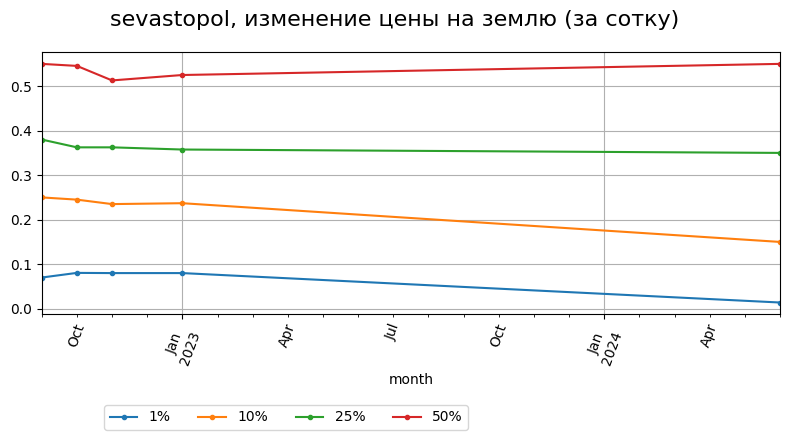

In [48]:
place = 'sevastopol'

fig, ax = plt.subplots(figsize=(8,4) )
stat.loc[(place,),cols].plot( grid=True,ax=ax,legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю (за сотку)', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [49]:
# place = 'sevastopol'

# fig, ax = plt.subplots(1,2,figsize=(17,7),sharey=True )

# stat.loc[(place,),cols].plot( grid=True,ax=ax[1],legend=False, rot=70, style='.-' )   
# # stat_history.loc[(place,),cols].plot( grid=True,ax=ax[0],legend=False, rot=70, style='.-' )   

# fig.suptitle(f'{place}, изменение цены на землю (за сотку)', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

In [50]:
# place = 'bahchisaray'

# fig, ax = plt.subplots(1,2,figsize=(17,7),sharey=True )

# stat.loc[(place,),cols].plot( grid=True,ax=ax[1],legend=False, rot=70, style='.-' )   
# stat_history.loc[(place,),cols].plot( grid=True,ax=ax[0],legend=False, rot=70, style='.-' )   

# fig.suptitle(f'{place}, изменение цены на землю (за сотку)', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

In [51]:
# place = 'sudak'

# fig, ax = plt.subplots(1,2,figsize=(17,7),sharey=True )

# stat.loc[(place,),cols].plot( grid=True,ax=ax[1],legend=False, rot=70, style='.-' )   
# stat_history.loc[(place,),cols].plot( grid=True,ax=ax[0],legend=False, rot=70, style='.-' )   

# fig.suptitle(f'{place}, изменение цены на землю (за сотку)', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

# актуальная цена

In [52]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

30030

3898

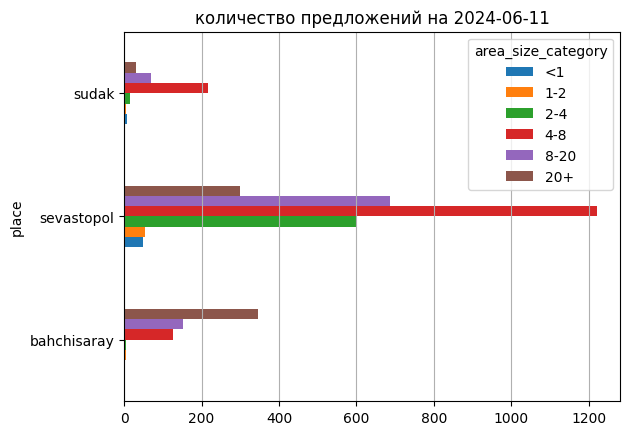

In [53]:
(
gdf_last
.groupby(['area_size_category','place'],observed=False)['url'].count().reset_index()
.pivot(index='place', columns='area_size_category', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [54]:
(
    gdf_last
    .groupby(['place','area_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean   std  min   1%   5%  10%  25%  \
place       area_size_category                                                
bahchisaray <1                    2.00  0.90  0.14 0.80 0.80 0.81 0.82 0.85   
            1-2                   5.00  2.60  2.53 0.50 0.54 0.70 0.90 1.50   
            2-4                   6.00  3.37  1.39 1.80 1.83 1.98 2.15 2.58   
            4-8                 125.00  2.01  1.28 0.15 0.30 0.40 0.49 1.10   
            8-20                152.00  2.22  2.40 0.23 0.33 0.48 0.60 0.90   
            20+                 345.00  5.54 10.55 0.01 0.22 0.46 0.60 1.10   
sevastopol  <1                   48.00  3.04  1.02 0.80 0.80 1.12 1.27 2.50   
            1-2                  55.00  3.66  2.94 0.55 0.66 0.99 1.38 2.20   
            2-4                 599.00  3.33  1.97 0.65 1.30 1.70 1.95 2.30   
            4-8                1220.00  3.97  2.93 0.35 0.85 1.35 1.70 2.50   
            8-20                687.00  5.48  7.87 0.59 0.75 1.40 1.80 2.70   
            20+                 298.00  9.35 20.77 0.00 0.79 1.39 1.80 2.60   
sudak       <1                    8.00  1.24  1.03 0.50 0.50 0.52 0.54 0.62   
            1-2                   5.00  4.40  1.90 2.00 2.04 2.20 2.40 3.00   
            2-4                  16.00  5.47  4.65 1.60 1.65 1.86 2.27 3.00   
            4-8                 217.00  3.52  3.24 0.00 0.63 1.10 1.20 1.80   
            8-20                 70.00  5.68  4.77 0.88 0.96 1.15 1.78 2.99   
            20+                  30.00 10.62  8.29 0.80 1.00 2.04 2.83 4.88   

                                50%   75%   90%    max  
place       area_size_category                          
bahchisaray <1                 0.90  0.95  0.98   1.00  
            1-2                2.00  2.00  5.00   7.00  
            2-4                3.20  3.68  4.75   5.80  
            4-8                1.95  2.50  3.76   6.90  
            8-20               1.60  2.60  3.50  16.20  
            20+                2.20  5.00 12.30 100.00  
sevastopol  <1                 3.15  3.73  4.06   4.90  
            1-2                3.20  4.20  5.66  18.50  
            2-4                3.00  3.80  4.50  22.40  
            4-8                3.30  4.50  6.40  36.00  
            8-20               4.00  5.50  8.94 120.00  
            20+                3.50  4.78 16.00 157.50  
sudak       <1                 0.80  1.50  2.13   3.60  
            1-2                4.80  5.50  6.22   6.70  
            2-4                4.00  5.72  9.35  20.00  
            4-8                2.81  3.95  6.00  30.00  
            8-20               4.10  6.50 11.50  22.00  
            20+                7.40 15.45 22.50  30.00

# цены на карте

In [55]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [56]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [57]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [58]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [59]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [60]:
# gdf_last.query('place=="sevastopol"')[['priceM']].describe([.9,.95,.99]).T

In [61]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    # .sjoin( gdf_last.query('(place=="sevastopol")&(priceM<10.0)'), how='inner',)
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    [['log_priceMU','priceMU']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceMU','geometry','log_priceMU',]]
    .explore(column='log_priceMU',cmap='rainbow')
)

## Судак

In [62]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [63]:
# gdf_last.query('place=="sudak"')[['priceM']].describe([.9,.95,.99]).T

In [64]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
   [['log_priceMU','priceMU']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceMU','geometry','log_priceMU',]]
    .explore(column='log_priceMU',cmap='rainbow')
)

# районы Севастополя

In [65]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [66]:
display(frames)

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка (старый)","POLYGON ((33.52932 44.59395, 33.53014 44.59336, 33.53265 44.59419, 33.53374 44.59431, 33.53651 44.59412, 33.54230 44.59142, 33.54644 44.58708, 33.54577 44.58522, 33.54406 44.58269, 33.54076 44.58366, 33.53883 44.58383, 33.53664 44.58511, 33.53142 44.58626, 33.53025 44.58780, 33.53048 44.58861, 33.53046 44.58847, 33.53167 44.59039, 33.53092 44.59122, 33.52951 44.59116, 33.52879 44.59244, 33.52895 44.59355, 33.52932 44.59395))"
6,"Севастополь, кр.горка (новый)","POLYGON ((33.54571 44.58517, 33.54652 44.58705, 33.54904 44.58565, 33.55000 44.58541, 33.55054 44.58522, 33.55089 44.58423, 33.55253 44.58415, 33.55326 44.58470, 33.55368 44.58431, 33.55371 44.58320, 33.55522 44.58246, 33.55548 44.58219, 33.55564 44.58115, 33.55564 44.58115, 33.55644 44.58055, 33.55694 44.57984, 33.55718 44.57912, 33.55936 44.57821, 33.56045 44.57706, 33.56229 44.57552, 33.56283 44.57476, 33.55749 44.57202, 33.55674 44.57395, 33.55618 44.57483, 33.55600 44.57601, 33.55286 44.57827, 33.55293 44.57910, 33.55259 44.58172, 33.55269 44.58302, 33.55003 44.58331, 33.54838 44.58436, 33.54571 44.58509, 33.54571 44.58517))"
7,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"
8,"Севастополь, Благополучный","POLYGON ((33.56498 44.57145, 33.56348 44.57083, 33.56274 44.57070, 33.56182 44.57017, 33.56179 44.56990, 33.55967 44.56941, 33.55751 44.57190, 33.55756 44.57213, 33.56302 44.57463, 33.56498 44.57145))"


In [67]:
frames.explore('area_name', legend=True)

In [68]:
area_name=[
    #'Севастополь, парк 60-летия СССР',
    #'Севастополь, Хрусталёва/Хрюкина',
    #'Севастополь, район Острякова',
    #'Севастополь, Малахов курган',
    'Севастополь, кр.горка (старый)',
    'Севастополь, кр.горка (новый)',
    'Севастополь, Благополучный',
    ]

In [69]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_ = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_[['title','priceM','address','geometry']].explore( legend=False)

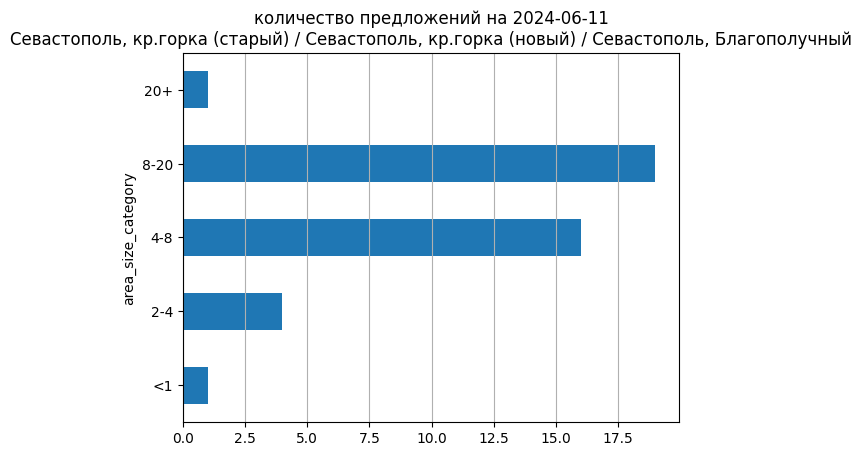

In [70]:
(
    gdf_
    .groupby(['area_size_category'], observed=True)['url'].count()
    .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
    .grid(axis='x')    
)

----

In [71]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 
# gdf_local_history = gdf_history.sjoin( frame_, how='inner', predicate='within') 

In [72]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = (
    gdf_local
    .groupby(['month'],observed=True)
    ['priceMU'].describe(percentiles=percentiles)
)
# stat_history = (
#     gdf_local_history
#     .groupby(['dt'],observed=True)
#     ['priceMU'].describe(percentiles=percentiles)
# )

display( stat )
# display( stat_history )

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,max
month,,,,,,,,,,,,
2022-09,389.00,0.62,0.27,0.17,0.17,0.34,0.37,0.48,0.56,0.68,0.85,1.78
2022-10,90.00,0.59,0.19,0.16,0.20,0.35,0.40,0.49,0.56,0.67,0.78,1.50
2022-11,219.00,0.58,0.22,0.15,0.20,0.38,0.40,0.47,0.53,0.62,0.85,2.00
2023-01,29.00,0.61,0.26,0.14,0.19,0.33,0.39,0.48,0.53,0.70,0.94,1.37
2024-06,161.00,0.82,0.59,0.09,0.09,0.21,0.41,0.49,0.59,0.90,1.60,3.70


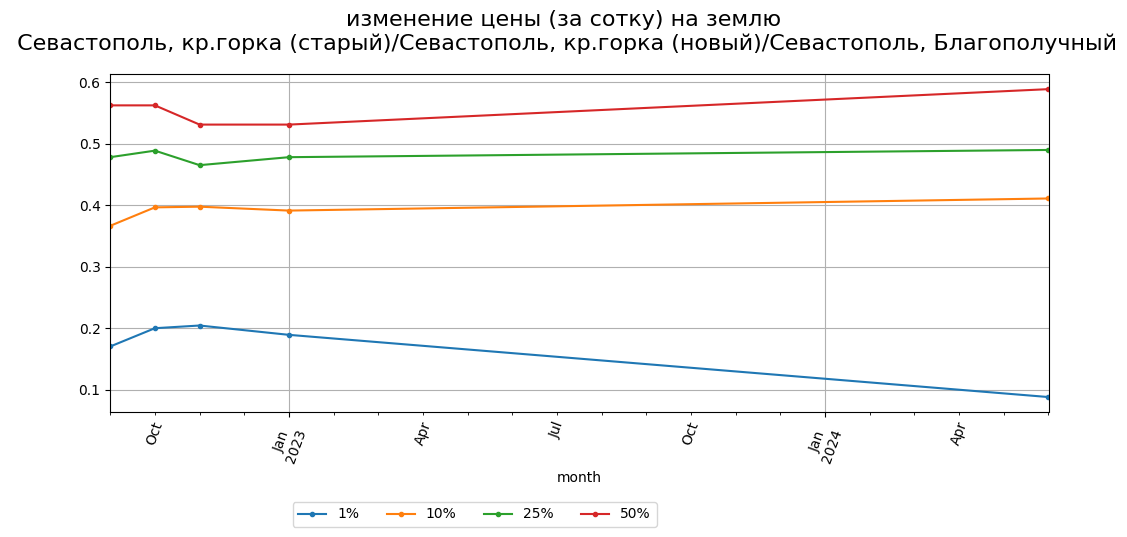

In [76]:
fig, ax = plt.subplots(figsize=(10,5) )

stat[cols].plot( grid=True,ax=ax,legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены (за сотку) на землю\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [73]:
# fig, ax = plt.subplots(2,len(sizes),figsize=(17,12), sharey=True )

# for i,s in enumerate(sizes): 
#     stat.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[1][i],legend=False, rot=70, style='.-' )   
#     stat_history.loc[(s),cols].plot(title=f'цена {s}m2', grid=True,ax=ax[0][i],legend=False, rot=70, style='.-' )   

# fig.suptitle(f'изменение цены на землю\n {'/'.join(area_name)}', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(17,7),sharey=True )

# stat[cols].plot( grid=True,ax=ax[1],legend=False, rot=70, style='.-' )   
# stat_history[cols].plot( grid=True,ax=ax[0],legend=False, rot=70, style='.-' )   

# fig.suptitle(f'изменение цены (за сотку) на землю\n {'/'.join(area_name)}', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()